In [1]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob
from biomart import BiomartServer
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gseapy as gp
import os

from sklearn import decomposition
from sklearn import preprocessing

from scripts import aesthetics

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 1000)

# Analyze SV impact on RNA

In `pgsvs-sv-impact-on-rna-generate.ipynb`, we have generate a huge dataset that fully details the impact of somatic SVs on tumor RNA expression. 

Here, we explore that dataset in further detail. It was getting cumbersome needing to work around generating the data.

# Import our data

We have a ton of data to import (the drawback of having multiple notebooks). I've short-cutted what data needs to be imported by exporting already formatted in data in `sv-impact-on-rna-generate`

In [2]:
analysis_tpms = pd.read_csv('data/tpms-for-sv-rna-analysis.csv')
analysis_tpms = analysis_tpms.iloc[:, 2:].set_index('gene_symbol')

analysis_dosages = pd.read_csv('data/dosages-for-sv-rna-analysis.csv')
analysis_dosages = analysis_dosages.iloc[:, 3:].set_index('ID')

analysis_svs = pd.read_csv('data/svs-for-sv-rna-analysis.csv')

# and our actual results
sv_rna_results = pd.read_csv('data/sv-expression-results/sv-gene-rna-results.csv')

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (34,35,37,39,41,45,46,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
analysis_tpms.head(2)

,PT_02SNWVRF,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_21PJ8R0Z,PT_26E4RFYV,PT_2JZNQGTR,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_3VNMNFT6,PT_4Y3P2N1P,PT_56ZM694R,PT_5E269C8Z,PT_5FCYBT0S,PT_69AGBVQ5,PT_6DHGCDRP,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_81RSHW1D,PT_82D2FJV2,PT_8DFBAQVQ,PT_9A9Q2YB3,PT_9QQ37AWW,PT_9X3MV3GW,PT_A77B7F2F,PT_AGYJR7PZ,PT_AQS8CCAB,PT_ASJZTDRF,PT_ATQMV6B3,PT_B39849MF,PT_C3YC0C9Q,PT_D5BYDHZ9,PT_DCBZYQAX,PT_E3R0MRXN,PT_E6CZS2KF,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FZ3XEWEK,PT_GGJ9E0VV,PT_GSWXPFPQ,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K579G3KQ,PT_KBVX8B37,PT_M4ETZ912,PT_M8RHAK5K,PT_MK375DCF,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_QH23VVKW,PT_R94DDN50,PT_RVTVP55V,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V3BXBVVV,PT_V65ESGCE,PT_VVVS471N,PT_W6AVZF18,PT_WWRAC6EH,PT_X8N7GE8X,PT_XPTE7785,PT_YGW6KQHQ,PT_YMDFCE4V,PT_YS31MFW0,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZT2NW6WA
gene_symbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.61,2.15,5.05,9.24,1.38,4.27,2.02,3.17,5.85,6.36,3.48,3.11,2.27,5.13,4.91,5.14,9.19,4.50,2.19,5.56,2.22,3.48,12.82,3.93,5.42,15.09,6.02,7.13,5.19,3.77,15.50,2.43,2.27,2.85,3.30,11.01,3.75,4.35,6.82,8.82,5.47,6.03,13.90,4.05,3.34,10.79,4.17,4.58,5.50,3.37,5.51,9.22,5.25,6.79,9.47,3.72,7.45,2.37,7.13,7.82,4.77,5.72,6.19,1.63,6.56,3.98,4.65,3.64,2.78,3.71,16.48,19.99,4.63,4.94,4.78,2.71,7.36,2.39,2.21,3.59,5.76,4.59,13.63,5.41,2.71,5.58,4.73,13.37,10.42
DPM1,6.62,7.87,9.53,6.47,8.50,8.60,4.42,14.89,6.82,8.34,11.18,6.19,14.00,9.55,10.03,10.89,7.57,10.69,16.08,9.30,8.82,6.57,8.18,8.04,6.04,10.48,10.56,6.59,9.23,9.81,7.94,6.79,13.07,11.07,15.11,8.91,16.16,7.94,6.96,8.88,7.65,8.60,12.84,7.12,4.40,5.96,6.23,9.24,8.51,4.64,9.08,7.29,9.21,12.98,8.29,6.15,12.28,11.06,4.80,9.61,7.01,7.17,8.40,8.62,9.24,10.62,8.02,8.32,11.61,7.05,11.15,10.57,7.43,9.57,9.12,6.07,7.61,9.08,7.77,6.19,9.14,10.08,11.38,5.59,7.46,4.74,8.39,6.96,10.87


In [4]:
analysis_dosages.head(2)

,PT_1X6CJ589,PT_2QB9MP9J,PT_2RZN4HR2,PT_4Y3P2N1P,PT_5E269C8Z,PT_7APMD0HG,PT_82D2FJV2,PT_F2AFSP66,PT_FZ3XEWEK,PT_HB9JT4G5,PT_M4ETZ912,PT_NK39AFPG,PT_P111JVHP,PT_PDYCQB6P,PT_PFRE83H3,PT_RVTVP55V,PT_SBS3N6ZT,PT_XPTE7785,PT_YGW6KQHQ,PT_11XN6CG5,PT_1EQHANKW,PT_1RH3DTPB,PT_6WE8JADD,PT_9QQ37AWW,PT_AQS8CCAB,PT_F0QD1YWQ,PT_HYJB8Y4N,PT_TTHE7B08,PT_V65ESGCE,PT_YS31MFW0,PT_EXZSSRGH,PT_HA7TBZ1V,PT_JD8FVX6G,PT_JYRSHSWJ,PT_ASJZTDRF,PT_ZK8Z4WAK,PT_E6CZS2KF,PT_21PJ8R0Z,PT_2Y7Q85BM,PT_3VNMNFT6,PT_DCBZYQAX,PT_E3R0MRXN,PT_K579G3KQ,PT_MK375DCF,PT_R94DDN50,PT_V3BXBVVV,PT_VVVS471N,PT_YMDFCE4V,PT_2JZNQGTR,PT_A77B7F2F,PT_JBQT2QPG,PT_SV8ETF29,PT_M8RHAK5K,PT_56ZM694R,PT_ATQMV6B3,PT_K3QMVST1,PT_WWRAC6EH,PT_1X9YQF9W,PT_81RSHW1D,PT_B39849MF,PT_C3YC0C9Q,PT_GGJ9E0VV,PT_QH23VVKW,PT_ZT2NW6WA,PT_02SNWVRF,PT_69AGBVQ5,PT_7E6A5N3P,PT_Z4S0193A,PT_1396H6SD,PT_5FCYBT0S,PT_8DFBAQVQ,PT_9X3MV3GW,PT_GSWXPFPQ,PT_KBVX8B37,PT_PV869ZYE,PT_Q50YZ2T5,PT_QF2A2F08,PT_W6AVZF18,PT_X8N7GE8X,PT_D5BYDHZ9,PT_6DHGCDRP,PT_70BK6DFW,PT_7BAFX5PZ,PT_HZ4VWQP5,PT_SDPQ63J1,PT_K0BJPWY9,PT_9A9Q2YB3,PT_AGYJR7PZ,PT_26E4RFYV
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PedSV.2.5.2_CNV_chr1_1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,0.0,2.0,0.0,3.0,2.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,1.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,3.0,1.0,2.0
PedSV.2.5.2_DUP_chr1_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN


In [5]:
analysis_svs.head(2)

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR,SL_MAX,SL_MEAN,SOURCE,STATUS,STRANDS,SVLEN,SVTYPE,TRUTH_AC,TRUTH_AF,TRUTH_AN,TRUTH_VID,UNRESOLVED_TYPE,VAR_PPV,VAR_SENSITIVITY,VAR_SPECIFICITY,N_BI_GENOS,N_HOMREF,N_HET,N_HOMALT,FREQ_HOMREF,FREQ_HET,FREQ_HOMALT,CN_NUMBER,CN_COUNT,CN_FREQ,CN_NONREF_COUNT,CN_NONREF_FREQ,MALE_AN,MALE_AC,MALE_AF,MALE_N_BI_GENOS,MALE_N_HOMREF,MALE_N_HET,MALE_N_HOMALT,MALE_FREQ_HOMREF,MALE_FREQ_HET,MALE_FREQ_HOMALT,MALE_CN_NUMBER,MALE_CN_COUNT,MALE_CN_FREQ,MALE_CN_NONREF_COUNT,MALE_CN_NONREF_FREQ,MALE_N_HEMIREF,MALE_N_HEMIALT,MALE_FREQ_HEMIREF,MALE_FREQ_HEMIALT,FEMALE_AN,FEMALE_AC,FEMALE_AF,FEMALE_N_BI_GENOS,FEMALE_N_HOMREF,FEMALE_N_HET,FEMALE_N_HOMALT,FEMALE_FREQ_HOMREF,FEMALE_FREQ_HET,FEMALE_FREQ_HOMALT,FEMALE_CN_NUMBER,FEMALE_CN_COUNT,FEMALE_CN_FREQ,FEMALE_CN_NONREF_COUNT,FEMALE_CN_NONREF_FREQ,case_control_AFR_AN,case_control_AFR_AC,case_control_AFR_AF,case_control_AFR_N_BI_GENOS,case_control_AFR_N_HOMREF,case_control_AFR_N_HET,case_control_AFR_N_HOMALT,case_control_AFR_FREQ_HOMREF,case_control_AFR_FREQ_HET,case_control_AFR_FREQ_HOMALT,case_control_AFR_CN_NUMBER,case_control_AFR_CN_COUNT,case_control_AFR_CN_FREQ,case_control_AFR_CN_NONREF_COUNT,case_control_AFR_CN_NONREF_FREQ,case_control_AFR_MALE_AN,case_control_AFR_MALE_AC,case_control_AFR_MALE_AF,case_control_AFR_MALE_N_BI_GENOS,case_control_AFR_MALE_N_HOMREF,case_control_AFR_MALE_N_HET,case_control_AFR_MALE_N_HOMALT,case_control_AFR_MALE_FREQ_HOMREF,case_control_AFR_MALE_FREQ_HET,case_control_AFR_MALE_FREQ_HOMALT,case_control_AFR_MALE_CN_NUMBER,case_control_AFR_MALE_CN_COUNT,case_control_AFR_MALE_CN_FREQ,case_control_AFR_MALE_CN_NONREF_COUNT,case_control_AFR_MALE_CN_NONREF_FREQ,case_control_AFR_MALE_N_HEMIREF,case_control_AFR_MALE_N_HEMIALT,case_control_AFR_MALE_FREQ_HEMIREF,case_control_AFR_MALE_FREQ_HEMIALT,case_control_AFR_FEMALE_AN,case_control_AFR_FEMALE_AC,case_control_AFR_FEMALE_AF,case_control_AFR_FEMALE_N_BI_GENOS,case_control_AFR_FEMALE_N_HOMREF,case_control_AFR_FEMALE_N_HET,case_control_AFR_FEMALE_N_HOMALT,case_control_AFR_FEMALE_FREQ_HOMREF,case_control_AFR_FEMALE_FREQ_HET,case_control_AFR_FEMALE_FREQ_HOMALT,case_control_AFR_FEMALE_CN_NUMBER,case_control_AFR_FEMALE_CN_COUNT,case_control_AFR_FEMALE_CN_FREQ,case_control_AFR_FEMALE_CN_NONREF_COUNT,case_control_AFR_FEMALE_CN_NONREF_FREQ,case_control_AMR_AN,case_control_AMR_AC,case_control_AMR_AF,case_control_AMR_N_BI_GENOS,case_control_AMR_N_HOMREF,case_control_AMR_N_HET,case_control_AMR_N_HOMALT,case_control_AMR_FREQ_HOMREF,case_control_AMR_FREQ_HET,case_control_AMR_FREQ_HOMALT,case_control_AMR_CN_NUMBER,case_control_AMR_CN_COUNT,case_control_AMR_CN_FREQ,case_control_AMR_CN_NONREF_COUNT,case_control_AMR_CN_NONREF_FREQ,case_control_AMR_MALE_AN,case_control_AMR_MALE_AC,case_control_AMR_MALE_AF,case_control_AMR_MALE_N_BI_GENOS,case_control_AMR_MALE_N_HOMREF,case_control_AMR_MALE_N_HET,case_control_AMR_MALE_N_HOMALT,case_control_AMR_MALE_FREQ_HOMREF,case_control_AMR_MALE_FREQ_HET,case_control_AMR_MALE_FREQ_HOMALT,case_control_AMR_MALE_CN_NUMBER,case_control_AMR_MALE_CN_COUNT,case_control_AMR_MALE_CN_FREQ,case_control_AMR_MALE_CN_NONREF_COUNT,case_control_AMR_MALE_CN_NONREF_FREQ,case_control_AMR_MALE_N_HEMIREF,case_control_AMR_MALE_N_HEMIALT,case_control_AMR_MALE_FREQ_HEMIREF,case_control_AMR_MALE_FREQ_HEMIALT,case_control_AMR_FEMALE

In [6]:
sv_rna_results.head(2)

,name,#chrom,start,end,svtype,sv_coding_counts,sv_non-coding_counts,num_samples_nonzero,num_samples_genotyped,af,average_cn,sv_effect,genic_relationship,gene,mean_exp,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p,ordinal_p,ordinal_coef
0,PedSV.2.5.2_CNV_chr1_6,chr1,257666,262901,CNV,0.0,1.0,17,89,NaN,0.179775,non-coding,PREDICTED_NEAREST_TSS,OR4F29,0.266629,15,0.492045,0.247333,0.270541,0.912668,0.582179,-0.188116
1,PedSV.2.5.2_CNV_chr1_7,chr1,262333,288667,CNV,0.0,1.0,62,89,NaN,0.932584,non-coding,PREDICTED_NEAREST_TSS,OR4F29,0.266629,62,0.489736,0.255484,0.292222,0.620135,0.461080,-0.181469


# Diving in

This data is super hard to wrap my head around. We'll start by answering some very straightforward questions.

## Do coding SVs affect expression? What about noncoding SVs?

To begin, I want to answer this question for SVs that are present in only one sample and "affect" only one gene. Much easier to think about.

In [7]:
single_gene_sample_svs = sv_rna_results[(sv_rna_results['sv_coding_counts'] + sv_rna_results['sv_non-coding_counts'] == 1) &
                                        (sv_rna_results['num_samples_nonzero'] == 1)]

single_gene_sample_svs['sv_effect'].value_counts()

non-coding    8684
coding         189
Name: sv_effect, dtype: int64

Alright, that's easy enough. Let's just examine the "significance" of these results, using the rank deviation approach we've devised.

coding p = 0.021904179065701523 mean = 0.45051055223149283
non-coding p = 0.99996011411991 mean = 0.5027676478390052


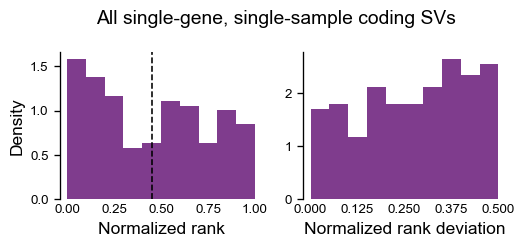

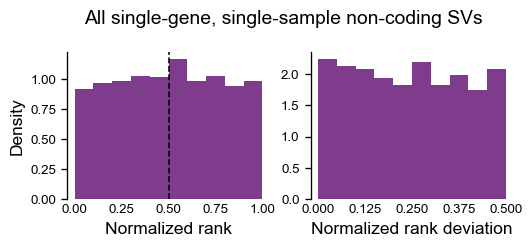

In [8]:
for sv_effect in ['coding', 'non-coding']:
    
    ss_sg_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
    rank_deviation = np.abs(0.5 - ss_sg_svs['mean_greater_0_dosage_rank'])
    
    fig, axes = plt.subplots(1, 2, figsize = (6, 2))
    axes[0].hist(ss_sg_svs['mean_greater_0_dosage_rank'], 
                 bins = np.arange(0, 1.1, 0.1), density = True)
    axes[0].axvline(x = ss_sg_svs['mean_greater_0_dosage_rank'].mean(), linestyle = 'dashed', color = 'black')
    axes[1].hist(rank_deviation, bins = np.arange(0, 0.55, 0.05),
                 density = True)

    for ax in axes:
        sns.despine(ax = ax, bottom = True)
        ax.tick_params(axis = 'x', length = 0)

    axes[0].set_xlim([-0.04, 1.04])
    axes[1].set_xlim([-0.02, 0.52])
    axes[1].set_xticks([0, 0.125, 0.25, 0.375, 0.5])

    axes[0].set_xlabel('Normalized rank')
    axes[1].set_xlabel('Normalized rank deviation')
    axes[0].set_ylabel('Density')
    
    # calculate a p value
    num_genes = len(ss_sg_svs)
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p = 1 - ref_dist.cdf(rank_deviation.mean())
    print(sv_effect, 'p =', p, 'mean =', ss_sg_svs['mean_greater_0_dosage_rank'].mean())

    fig.suptitle(f'All single-gene, single-sample {sv_effect} SVs', y = 1.1)
    fig.savefig(f'images/single-sample-single-gene-{sv_effect}-effect-on-expression.png', bbox_inches = 'tight')

So the coding SVs do have more of an effect than the noncoding SVs.

In [9]:
genic_rel_cols = {'coding': ['PREDICTED_LOF', 'PREDICTED_COPY_GAIN', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_PARTIAL_EXON_DUP'],
                  'non-coding': ['PREDICTED_NEAREST_TSS', 'PREDICTED_INTRONIC', 'PREDICTED_UTR', 'PREDICTED_PROMOTER']}

## Examine impact of coding SVs by sv-type

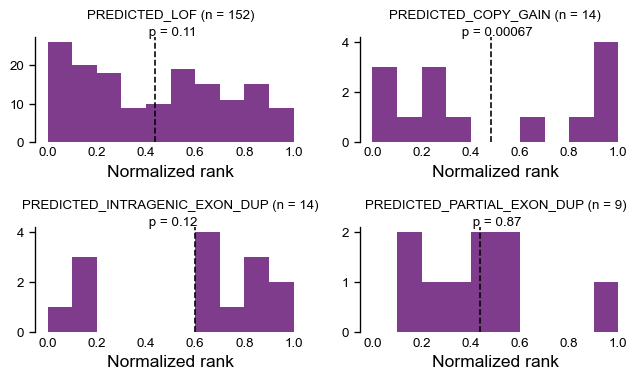

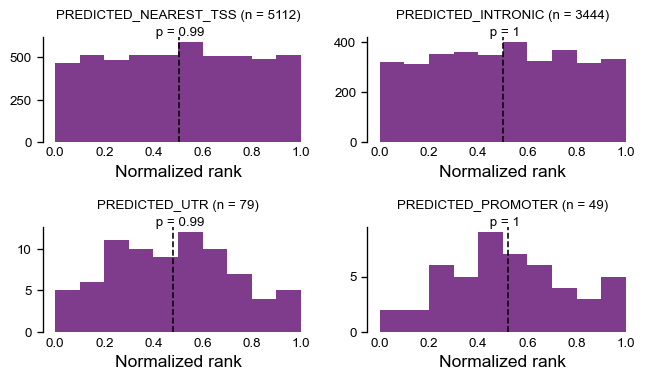

In [10]:
for sv_effect in ['coding', 'non-coding']:
    
    fig, axes = plt.subplots(2, 2, figsize = (8, 4), gridspec_kw = {'hspace': 0.8, 'wspace': 0.2})

    gr_cols = genic_rel_cols[sv_effect]
    ss_sg_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
    
    for i, svtype in enumerate(gr_cols):

        ax = axes.flat[i]
        sv_subset = ss_sg_svs[ss_sg_svs['genic_relationship'] == svtype]
        num_genes = len(sv_subset)

        ax.hist(sv_subset['mean_greater_0_dosage_rank'],
                bins = np.arange(0, 1.1, 0.1), 
                label = svtype)
    
        sns.despine(ax = ax, bottom = True)
        ax.tick_params(axis = 'x', length = 0)
        ax.set_title(svtype + f' (n = {num_genes})', fontsize = 10, y = 1.1)

        num_genes = len(sv_subset)
        rank_deviation = np.abs(0.5 - sv_subset['mean_greater_0_dosage_rank'])
        ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
        p = 1 - ref_dist.cdf(rank_deviation.mean())
        ax.text(s = " p = {:.2g}".format(p), x = 0.5, y = 1.1, fontsize = 10,
                ha = 'center', va = 'top', transform = ax.transAxes)
        ax.set_xlabel('Normalized rank')

        mean = np.mean(sv_subset['mean_greater_0_dosage_rank'])
        ax.axvline(x = mean, color = 'black', linestyle = 'dashed')

That is super interesting... none of the different categories are significant except for copy gain--but even copy gain has several samples with very low ranks.

# Dig more into these coding effects

So apparently, coding SVs do have detectable effects on expression, and the direction of effect is slanted towards decreasing expression. I'd like to dig into this a little bit more.

In [11]:
coding_ss_sg_svs = single_gene_sample_svs.query('sv_effect == "coding"').copy()

Is there anything else that might explain some results here?

In [12]:
coding_ss_sg_svs['mean_greater_0_dosage_rank'].mean()

0.45051055223149283

Is there some issue with genotyping many of these SVs?

In [13]:
stats.spearmanr(coding_ss_sg_svs['num_samples_genotyped'], coding_ss_sg_svs['mean_greater_0_dosage_rank'])

SpearmanrResult(correlation=-0.011636030263743782, pvalue=0.8737373254833949)

Nope. Is it that highly expressed genes are more likely to have higher ranks?

In [14]:
stats.spearmanr(coding_ss_sg_svs['mean_exp'], coding_ss_sg_svs['mean_greater_0_dosage_rank'])

SpearmanrResult(correlation=-0.0901427593387281, pvalue=0.21737071390423518)

Nope. What about DEL vs. DUP, etc?

In [15]:
coding_ss_sg_svs['svtype'].value_counts()

DEL           138
DUP            44
CPX             3
INV             3
INS:ME:ALU      1
Name: svtype, dtype: int64

DEL 0.2664207133454066 0.09070138468686295
DUP 0.286055254880091 0.04876243027274063


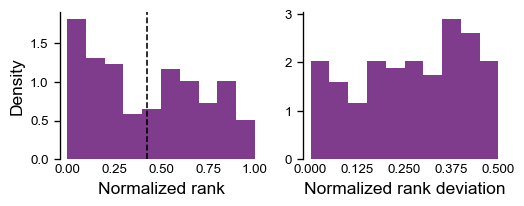

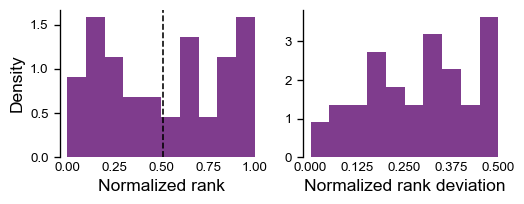

In [16]:
for svtype in ['DEL', 'DUP']:
    
    svtype_subset = coding_ss_sg_svs.query(f'svtype == "{svtype}"')
    
    num_genes = len(svtype_subset)
    rank_deviation = np.abs(0.5 - svtype_subset['mean_greater_0_dosage_rank'])
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
    p = 1 - ref_dist.cdf(rank_deviation.mean())
    
    print(svtype, rank_deviation.mean(), p)

    fig, axes = plt.subplots(1, 2, figsize = (6, 2))
    axes[0].hist(svtype_subset['mean_greater_0_dosage_rank'], 
                 bins = np.arange(0, 1.1, 0.1), density = True)
    axes[0].axvline(x = svtype_subset['mean_greater_0_dosage_rank'].mean(), linestyle = 'dashed', color = 'black')
    axes[1].hist(rank_deviation, bins = np.arange(0, 0.55, 0.05),
                 density = True)

    for ax in axes:
        sns.despine(ax = ax, bottom = True)
        ax.tick_params(axis = 'x', length = 0)

    axes[0].set_xlim([-0.04, 1.04])
    axes[1].set_xlim([-0.02, 0.52])
    axes[1].set_xticks([0, 0.125, 0.25, 0.375, 0.5])

    axes[0].set_xlabel('Normalized rank')
    axes[1].set_xlabel('Normalized rank deviation')
    axes[0].set_ylabel('Density')
    

Interesting, so DUPs maybe have a slightly higher effect size?

Nope, that's not it. Is it that these data actually represent a fraction of the total overall samples? Like for some reason, this is just reflecting the influence of some weird samples?

In [17]:
coding_sv_names = coding_ss_sg_svs['name'].tolist()
coding_sv_dosages = analysis_dosages.loc[coding_sv_names]

samples = []
for index, row in coding_sv_dosages.iterrows():
    s = row[row > 0]
    assert len(s) == 1
    
    samples.append(s.index[0])
    
sample_counts = pd.DataFrame(np.unique(samples, return_counts = True), index = ['sample', 'count']).T
sample_counts = sample_counts.sort_values(by = 'count', ascending = False)

In [18]:
sample_counts.head(6)

,sample,count
26,PT_AGYJR7PZ,8
44,PT_JD8FVX6G,6
35,PT_F0QD1YWQ,6
59,PT_RVTVP55V,5
52,PT_P111JVHP,5
24,PT_9X3MV3GW,5


In [19]:
sample_counts.shape

(75, 2)

So 75 out of 89 samples are represented here, which isn't bad. But that doesn't tell us if a subset of samples are actually driving the signal or not. Need to do a bit more work to figure that out.

In [20]:
coding_ss_sg_svs['rank_deviation'] = np.abs(0.5 - coding_ss_sg_svs['mean_greater_0_dosage_rank'])
coding_ss_sg_svs['sample_affected'] = samples

In [21]:
# how many samples have at least one SV in the top or bottom 10% by rank?
coding_ss_sg_svs['extreme_rank'] = coding_ss_sg_svs['rank_deviation'] > 0.40
num_extreme = coding_ss_sg_svs[coding_ss_sg_svs['extreme_rank']]['sample_affected'].value_counts()
print(num_extreme.shape[0], '\n')
print(num_extreme.head(5))

34 

PT_AGYJR7PZ    6
PT_11XN6CG5    2
PT_1RH3DTPB    2
PT_GSWXPFPQ    2
PT_9X3MV3GW    2
Name: sample_affected, dtype: int64


So 34 out of 75 of those samples have expression in an extreme rank, which I think is a good sign. Can we just check that if we subsample to individual samples, we get similar results?

In [22]:
p_vals = []
for i in range(10000):
    temp = coding_ss_sg_svs.sample(frac=1, replace = False)
    temp = temp.drop_duplicates(subset = ['sample_affected'])
    
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * len(temp))))
    p = 1 - ref_dist.cdf(temp['rank_deviation'].mean())
    p_vals.append(p)

In [23]:
(np.array(p_vals) < 0.05).mean()

0.3794

Interesting. Only 38% of the time, this subselection process results in a significant result. What if we drop samples that have more than 4 counts?

In [24]:
for cutoff in [4, 3, 2, 1]:
    fewer_than = sample_counts[sample_counts['count'] <= cutoff]['sample'].tolist()
    subset = coding_ss_sg_svs[coding_ss_sg_svs['sample_affected'].isin(fewer_than)]
    
    ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * len(subset))))
    p = 1 - ref_dist.cdf(subset['rank_deviation'].mean())
    
    print(subset['mean_greater_0_dosage_rank'].mean(), subset['rank_deviation'].mean(), p)

0.45837089321026636 0.27539557175268103 0.015869165114099526
0.45928623811656233 0.26887164308269823 0.07189921987273318
0.48967395993338253 0.2780683941473703 0.06762666005790574
0.5823315684175651 0.28933584462915835 0.1058555172807597


Still significant, and it remains borderline significant even as you drop it more. So I don't think individual samples are influencing things all that much. Interesting!

## Examine other coding contexts

I want to examine other coding contexts:

- Common SVs (those that affect many samples)
- CNVs

81, 0.49382716049382713
11868, 0.4822210987529491


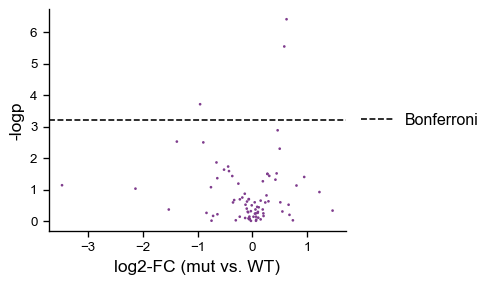

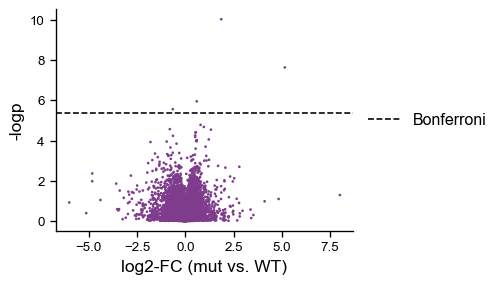

In [31]:
for sv_effect in ['coding', 'non-coding']:
    results = sv_rna_results.query(f'sv_effect == "{sv_effect}"')
    
    # select SVs with a good mix of samples with the SV and those without
    high_af_svs = results[(results['num_samples_nonzero'] >= 4) &
                          (results['num_samples_genotyped'] - results['num_samples_nonzero'] >= 4)].copy()
    
    high_af_svs = high_af_svs[(high_af_svs[f'sv_{sv_effect}_counts'] == 1)]
    print(high_af_svs.shape[0], end = ', ')
    
    high_af_svs['log2FC'] = np.log2(high_af_svs['mean_greater_0_exp'] / high_af_svs['mean_leq_0_exp'])
    high_af_svs['-logp'] = -np.log10(high_af_svs['ordinal_p'])
    print((high_af_svs['log2FC'] > 0).mean())
    
    fig, ax = plt.subplots(1, figsize = (4, 3))
    sns.scatterplot(x = 'log2FC', y = '-logp', data = high_af_svs, ec = None, s = 4)
    sns.despine()
    ax.set_xlabel('log2-FC (mut vs. WT)')
    ax.axhline(y = -np.log10(0.05 / len(high_af_svs)), linestyle = 'dashed', color = 'black', label = 'Bonferroni')
    ax.legend(bbox_to_anchor = (1, 0.5))
    
    # fig.savefig('images/high-af-coding-SV-expression-effect.png', bbox_inches = 'tight')

In [32]:
(high_af_svs['log2FC'] < 0).mean()

0.5176946410515673

# Examine our categories

We start by importing our category data

In [33]:
###########
### SVs ###
###########
nbl_coding_svs = pd.read_csv(
    "data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt",
    sep="\t",
)

nbl_noncoding_svs = pd.read_csv('data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_noncoding_SVs_in_each_category_list_combined_BURDEN_TESTING_with_col_names_11_3_23.txt', sep='\t')
nbl_noncoding_svs = nbl_noncoding_svs.rename(columns = {'emd': 'end'})

# combine the SVs
nbl_coding_svs['sv_category'] = 'coding'
nbl_noncoding_svs['sv_category'] = 'non-coding'

nbl_category_svs = pd.concat([nbl_coding_svs, nbl_noncoding_svs])
nbl_category_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding


In [34]:
#########################
### FRAMEWORK RESULTS ###
#########################
nbl_singleton_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_coding_framework_results[['af_category', 'sv_category']] = ['singleton', 'coding']

nbl_rare_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_coding_framework_results[['af_category', 'sv_category']] = ['rare', 'coding']

nbl_singleton_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_noncoding_framework_results[['af_category', 'sv_category']] = ['singleton', 'non-coding']

nbl_rare_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_noncoding_framework_results[['af_category', 'sv_category']] = ['rare', 'non-coding']

nbl_framework_results = pd.concat([nbl_singleton_coding_framework_results, nbl_rare_coding_framework_results, 
                                   nbl_singleton_noncoding_framework_results, nbl_rare_noncoding_framework_results])

In [35]:
nbl_framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding


In [36]:
nbl_coding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_categories_neuroblastoma_coding_8_17_23.txt",
    sep="\t",
)

nbl_noncoding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_rare_categories_neuroblastoma_noncoding_10_2_23.txt",
    sep="\t",
)

## Crunch these categories

We'll replicate an example we've done previously

In [37]:
significant_categories = nbl_framework_results.query('negative_log10_p_value > 3.5')
coding_categories = significant_categories.query('sv_category == "coding"')

In [38]:
significant_categories.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding


In [39]:
p_vals = []
for index, row in significant_categories.iterrows():
    cat = row['category_name']
    sv_effect = row['sv_category']
    
    svs_in_category = nbl_category_svs[nbl_category_svs['category'] == cat]['SV'].tolist()

    category_rna_results = sv_rna_results[sv_rna_results['name'].isin(svs_in_category)]
    
    
    category_rna_results = category_rna_results[(category_rna_results[f'sv_{sv_effect}_counts'] == 1) & 
                                                (category_rna_results['sv_effect'] == sv_effect)]
    
    try:
        rank_deviation = np.mean(np.abs(0.5 - category_rna_results['mean_greater_0_dosage_rank']))
    
        num_genes = len(category_rna_results)
        ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
        p_mean = 1 - ref_dist.cdf(rank_deviation)
        rank_mean = np.mean(category_rna_results['mean_greater_0_dosage_rank'])
        
    except:
        p_mean = np.nan
        rank_mean = np.nan
        
    p_vals.append([cat, p_mean, rank_mean])
    
p_vals = pd.DataFrame(p_vals, columns = ['category_name', 'p_mean', 'rank_mean'])

In [40]:
p_vals

,category_name,p_mean,rank_mean
0,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,0.001927,0.391780
1,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,0.001779,0.367320
2,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,0.001779,0.367320
3,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,0.000375,0.371611
4,ANY.SINGLETON.ANY.unconstrained.ANY.protein_co...,0.027843,0.354664
...,...,...,...
72,DEL.RARE.PREDICTED_NONCODING_BREAKPOINT.neurob...,0.566319,0.267045
73,DUP.RARE.ANY.neuroblastoma_chromHMM15_EnhBiv_c...,0.305795,0.667898
74,DEL.RARE.PREDICTED_NONCODING_SPAN.recombinatio...,0.792045,0.367424
75,ANY.RARE.PREDICTED_NONCODING_BREAKPOINT.neurob...,0.544327,0.681818


In [41]:
significant_categories_results = significant_categories.merge(p_vals, on = 'category_name')
significant_categories_results['-log10(cat_p)'] = -np.log10(significant_categories_results['p_value'])
significant_categories_results['-log10(p_mean)'] = -np.log10(significant_categories_results['p_mean'])

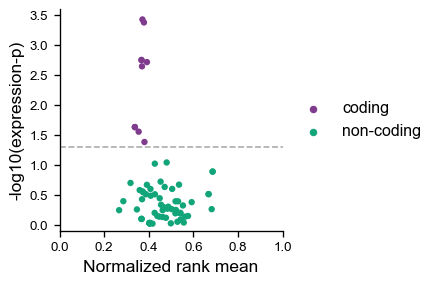

In [42]:
fig, ax = plt.subplots(1, figsize = (3, 3))
sns.scatterplot(x = 'rank_mean', y = '-log10(p_mean)', data = significant_categories_results, hue = 'sv_category', ec = None)
ax.set_xlabel('Normalized rank mean')
ax.set_ylabel('-log10(expression-p)')
sns.despine(ax = ax)
ax.set_xlim([-0.1, None])
ax.set_ylim([-0.1, None])
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'darkgrey')
ax.legend(bbox_to_anchor = (1, 0.5))
ax.set_xlim([0, 1])
fig.savefig('images/cwas-categories-expression-significance.png', bbox_inches = 'tight')

In [43]:
example_category = 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding'
svs_in_category = nbl_category_svs[nbl_category_svs['category'] == example_category]['SV'].tolist()
category_rna_results = sv_rna_results[sv_rna_results['name'].isin(svs_in_category)]
category_rna_results = category_rna_results[(category_rna_results[f'sv_coding_counts'] == 1) & 
                                            (category_rna_results['sv_effect'] == "coding")]

print(coding_ss_sg_svs['mean_greater_0_dosage_rank'].mean(), category_rna_results['mean_greater_0_dosage_rank'].mean())
print(stats.mannwhitneyu(coding_ss_sg_svs['mean_greater_0_dosage_rank'], category_rna_results['mean_greater_0_dosage_rank']))

indices = np.random.choice(range(len(coding_ss_sg_svs)), size = (37, 1000000))
iteration_means = coding_ss_sg_svs['mean_greater_0_dosage_rank'].values[indices].mean(axis = 0)
print((iteration_means < category_rna_results['mean_greater_0_dosage_rank'].mean()).mean())

0.45051055223149283 0.367320076807062
MannwhitneyuResult(statistic=4130.5, pvalue=0.08152124486851066)
0.047213


## Make heatmaps

In [44]:
def make_heatmap(category_rna_results):
    
    genes = category_rna_results['gene'].tolist()
    heatmap_exp = analysis_tpms.loc[genes]
    heatmap_cols = analysis_tpms.columns

    heatmap_exp_values = heatmap_exp.values

    # we now need to scramble the rows by sorting by expression
    ordered_indices = np.argsort(heatmap_exp_values, axis = 1)
    heatmap_exp_values = np.sort(heatmap_exp_values, axis = 1)

    # create a mask for 0 expression
    mask = (heatmap_exp_values == 0)
    masked_data = np.where(mask, heatmap_exp_values, np.nan)

    # convert heatmap data to zscore
    heatmap_exp_values = stats.zscore(heatmap_exp_values, axis = 1)
    
    fig = plt.figure(figsize=(10, 0.25 * heatmap_exp_values.shape[0]))
    gs = fig.add_gridspec(1)
    
    # plot the heatmap
    heatmap_ax = fig.add_subplot(gs[0])
    
    sns.heatmap(heatmap_exp_values, cmap="coolwarm", robust=True, 
                ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.02, 'shrink': 0.2})
    
    # label the colorbar
    cbar = heatmap_ax.collections[0].colorbar
    cbar.set_label('expression z-score')
    
    # apply a mask for 0 expression
    sns.heatmap(masked_data, cmap=['darkgrey'], annot=False, cbar=False, mask=~mask, 
                ax = heatmap_ax, label = '0 expression')

    heatmap_ax.set_yticks(np.arange(len(genes)) + 0.5)
    heatmap_ax.set_yticklabels(genes, rotation = 0, ha = 'right', fontstyle = 'italic');
    aesthetics.strip_axis(ax = heatmap_ax, y = 'label')
    heatmap_ax.tick_params(axis = 'y', length = 0)
    
    # label the samples with SVs
    label = True
    for i, row in category_rna_results.iterrows():
        sv = row['name']
        dosages = analysis_dosages.loc[sv]
        samples_with_sv = list(dosages[dosages > 0].index)

        for s in samples_with_sv:
            sorted_s = heatmap_cols[ordered_indices[i, :]]
            s_idx = list(sorted_s).index(s)
            label_s = 'sample with SV' if label else ''
            heatmap_ax.scatter(x = s_idx + 0.5, y = i + 0.5, color = 'black', s = 10, label = label_s)
            label = False
            
    heatmap_ax.legend(bbox_to_anchor = (0.75, -0.10))
    heatmap_ax.set_title(category, fontsize = 9)
    
    return fig

In [45]:
for index, row in significant_categories_results.iterrows():
    category = row['category_name']
    sv_effect = row['sv_category']
    p_mean = row['p_mean']
    
    path = f'data/cwas-results/expression-plots/{category}'
    if not os.path.isdir(path):
        os.mkdir(path)
        
    
    svs_in_category = nbl_category_svs[nbl_category_svs['category'] == category]['SV'].tolist()
    category_rna_results = sv_rna_results[(sv_rna_results['name'].isin(svs_in_category)) &
                                          (sv_rna_results['sv_effect'] == f'{sv_effect}')].sort_values(by = 'mean_greater_0_dosage_rank').reset_index(drop = True)
    if len(category_rna_results) == 0:
        continue

    # make and save the heatmap
    heatmap_fig = make_heatmap(category_rna_results)
    heatmap_fig.savefig(path + '/expression-heatmap.png', bbox_inches = 'tight')
    plt.close(heatmap_fig)
    
    # get the distribution of ranks
    rank_fig, axes = plt.subplots(2, 1, figsize = (4, 4), gridspec_kw = {'hspace': 0.5})

    for i, analysis in enumerate(['abs', 'dev']):
        if analysis == 'dev':
            data = np.abs(0.5 - category_rna_results['mean_greater_0_dosage_rank'])
            bins = np.arange(0, 0.55, 0.05)
            xlim = [-0.025, 0.50]
        else:
            data = category_rna_results['mean_greater_0_dosage_rank']
            bins = np.arange(0, 1.1, 0.1)
            xlim = [-0.05, 1.0]

        axes[i].hist(data, bins)
        label = '% expression rank of samples with SV' if analysis == 'abs' else 'rank deviation'  

        axes[i].set_xlabel(label)
        axes[i].set_ylabel('SV count')
        axes[i].set_xlim(xlim)
        aesthetics.strip_axis(ax = axes[i], x = 'label', y = 'ignore')

    p_label = "p_mean = {:.2g}".format(p_mean)
    axes[0].text(x = 0.5, y = 0.75, s = p_label, transform = axes[0].transAxes, fontsize = 10, ha = 'center')
    axes[0].set_title(category, fontsize = 8)

    rank_fig.savefig(path + '/expression-histogram.png', bbox_inches = 'tight')
    plt.close(rank_fig)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


# Examine adipogenesis

Alright, the last damn thing. I want to know if this stupid gene set is upregulated at all. We'll compare samples with an SV in the category vs. those that don't have one/

In [51]:
gene_sets = {}
with open('ref/gene-sets.txt') as gs_in:
    for line in gs_in:
        comp = line.strip().split('\t')
        db = comp[0]
        gs = comp[1]
        genes = comp[2:]
        gene_sets[db + ' | ' + gs] = genes

In [76]:
adipogenesis_genes = set(gene_sets['MSigDB_Hallmark_2020 | Adipogenesis']) & set(analysis_tpms.index)
len(adipogenesis_genes)

188

In [77]:
coding_cols = ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_COPY_GAIN']
noncoding_cols = ['PREDICTED_NEAREST_TSS', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']

In [78]:
# determine which rows have a gene of adipogenesis affected
affected_genes = analysis_svs[coding_cols + noncoding_cols].fillna('')

adipo = []
for index, row in affected_genes.iterrows():
    genes_affected = []
    for col in coding_cols + noncoding_cols:
        genes_affected += row[col].split(',')
        
    genes_affected = [g for g in genes_affected if g != '']
    
    if len(set(genes_affected) & set(adipogenesis_genes)):
        adipo.append(True)
    else:
        adipo.append(False)


In [109]:
svs_in_adipo = analysis_svs[adipo]['name'].tolist()
adipo_dosage = analysis_dosages.loc[svs_in_adipo]

# drop SVs present in more than 2 samples
adipo_dosage = adipo_dosage[adipo_dosage.sum(axis = 1) < 2]
adipo_dosage = adipo_dosage.sum(axis = 0)

In [110]:
ss = gp.ssgsea(data=analysis_tpms,
               gene_sets={'Adipogenesis': adipogenesis_genes},
               outdir=None,
               sample_norm_method='rank',
               no_plot=True,
               min_size=4)

signatures = ss.res2d
signatures.columns = ['sample', 'signature', 'enrichment_score', 'normalized_enrichment_score']

In [111]:
signatures = signatures.set_index('sample')
signatures.loc[adipo_dosage.index, 'adipogenesis_dosage'] = adipo_dosage

In [112]:
import scipy.stats

In [113]:
scipy.stats.spearmanr(signatures['normalized_enrichment_score'], signatures['adipogenesis_dosage'])

SpearmanrResult(correlation=-0.04837927494132474, pvalue=0.6525511674102056)

# Riaz's TAD Boundaries

Riaz has taken a look at the TAD boundary categories and "expanded them" to include all genes in the TAD. So effectively, a count for an SV in the TAD boundary leads to a count for all the genes in a TAD.

He's identified a list of these genes and would like to know if the expression within these samples is systematically effected. Let's take a look.

In [173]:
riaz_tads = pd.read_csv('data/CWAS data for Jett/TAD_category_of_interest_SVs_in_cases_tibble_subsetted_with_TAD_boundaries_TADs_and_genes_unique_with_samples_and_study_12_2_23.txt', sep='\t')
riaz_tads.head(2)

,SV_name,TAD_boundary_ID,gene,sample,study
0,PedSV.2.5.2_DEL_chr1_832,TAD_boundary_15,ARHGEF16,PT_HA7TBZ1V,GMKF
1,PedSV.2.5.2_DEL_chr1_832,TAD_boundary_15,MEGF6,PT_HA7TBZ1V,GMKF


In [174]:
riaz_tads.shape

(916, 5)

In [159]:
included_samples = list(analysis_tpms.columns)

In [160]:
len(set(riaz_tads['sample'])), len(set(riaz_tads['sample']) & set(included_samples))

(222, 35)

In [175]:
riaz_tads[riaz_tads['sample'].isin(included_samples)].shape

(105, 5)

In [164]:
subsamples = set(riaz_tads['sample']) & set(included_samples)
subgenes = riaz_tads[riaz_tads['sample'].isin(subsamples)]['gene']
print(len(subgenes), len(set(subgenes) & set(analysis_tpms.index)))

105 89


And only 96 of the genes are in the TPM matrix.

In [165]:
len(subsamples)

35

In [191]:
riaz_tad_rna_results = sv_rna_results[sv_rna_results['name'].isin(riaz_tads['SV_name'].tolist())].sort_values(by = 'mean_greater_0_dosage_rank').reset_index(drop = True)
riaz_tad_rna_results.shape

(40, 22)

In [192]:
riaz_tad_rna_results['mean_greater_0_dosage_rank'].mean()

0.4425809822361547

In [193]:
rank_deviation = np.abs(0.5 - riaz_tad_rna_results['mean_greater_0_dosage_rank'])
mean_dev_rank = np.mean(rank_deviation)
num_genes = riaz_tad_rna_results.shape[0]

print(mean_dev_rank)

0.25435606060606064


In [194]:
# now we do some statistics. A KS test, to start
p_ks = stats.kstest(rank_deviation, lambda x: 2 * x)[1]

# now do the sample mean test
ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
p_mean = 1 - ref_dist.cdf(mean_dev_rank)

print(p_ks, p_mean)

0.8659352714722139 0.4243125421792442


So nominally, these are not significant.

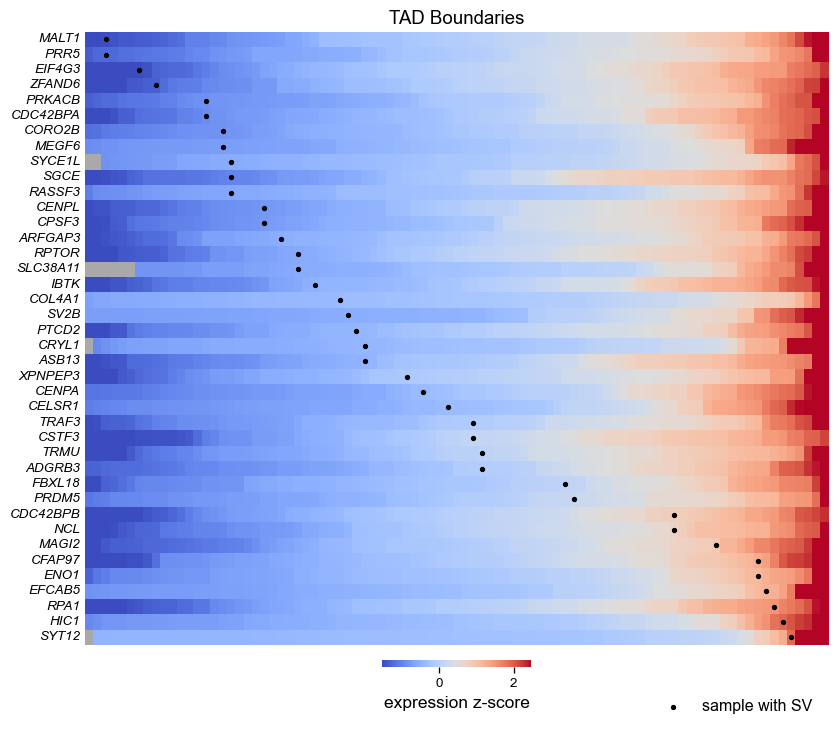

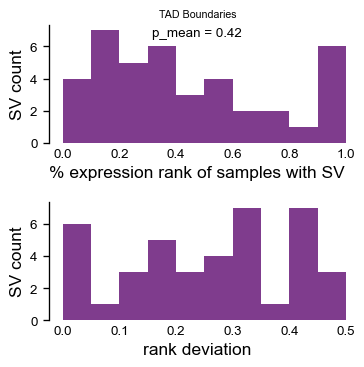

In [202]:
# make and save the heatmap
heatmap_fig = make_heatmap(riaz_tad_rna_results)
heatmap_fig.axes[0].set_title('TAD Boundaries')
heatmap_fig.savefig('data/cwas-results/expression-plots/tad-boundaries/expression-heatmap.png', bbox_inches = 'tight')

# get the distribution of ranks
rank_fig, axes = plt.subplots(2, 1, figsize = (4, 4), gridspec_kw = {'hspace': 0.5})

for i, analysis in enumerate(['abs', 'dev']):
    if analysis == 'dev':
        data = np.abs(0.5 - riaz_tad_rna_results['mean_greater_0_dosage_rank'])
        bins = np.arange(0, 0.55, 0.05)
        xlim = [-0.025, 0.50]
    else:
        data = riaz_tad_rna_results['mean_greater_0_dosage_rank']
        bins = np.arange(0, 1.1, 0.1)
        xlim = [-0.05, 1.0]

    axes[i].hist(data, bins)
    label = '% expression rank of samples with SV' if analysis == 'abs' else 'rank deviation'  

    axes[i].set_xlabel(label)
    axes[i].set_ylabel('SV count')
    axes[i].set_xlim(xlim)
    aesthetics.strip_axis(ax = axes[i], x = 'label', y = 'ignore')

p_label = "p_mean = {:.2g}".format(p_mean)
axes[0].text(x = 0.5, y = 0.90, s = p_label, transform = axes[0].transAxes, fontsize = 10, ha = 'center')
axes[0].set_title('TAD Boundaries', fontsize = 8)

rank_fig.savefig('data/cwas-results/expression-plots/tad-boundaries/expression-histogram.png', bbox_inches = 'tight')

In [197]:
heatmap_fig.axes[0]

<AxesSubplot:title={'center':'DEL.RARE.ANY.recombination_hotspot_conserved.ANY.lof_constrained.ANY.cosmic_and_germline_CPGs'}>